In [1]:
from datasets.load import load_samples
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [2]:
samples = load_samples('train', 'datasets')

In [37]:
import math

def draw_bbox(ax, name, box, col='r'):
    r = patches.Rectangle((box[0], box[1]), 
                          box[2] - box[0],
                          box[3] - box[1],
                          linewidth=3,
                          edgecolor=col,
                          facecolor='none')
    ax.add_patch(r)
    ax.text(box[0], box[1], name,
            bbox={'facecolor': col, 'linewidth': 0})

def draw_annotation(ax, classes):
    colors = plt.get_cmap('tab10')
    for idx, cl in enumerate(classes):
        col = colors(idx)
        for box in cl['bounds']:
            draw_bbox(ax, cl['name'], box, col)
            
def generate_pos_samples(samples, blowup=1):
    res = []
    for sample in samples:
        for cl in sample['classes']:
            if cl['name'] != 'waldo':
                continue
            for box in cl['bounds']:
                scales = np.random.uniform(low=1, high=10, size=(blowup,))
                for s in scales:
                    try:
                        ymin, ymax = box[1], box[3]
                        xmin, xmax = box[0], box[2]
                        sx = math.ceil((ymax - ymin)*s/2)
                        sy = math.ceil((xmax - xmin)*s/2)
                        ymin, ymax = ymin - sy, ymax + sy
                        xmin, xmax = xmin - sy, xmax + sy
                        
                        img = sample['img'][ymin:ymax, xmin:xmax]
                        if img.size != 0:
                            #print(img)
                            res.append(dict(
                                name = cl['name'],
                                img = img,
                                scale = 1/s,
                                bbox = [box[0] - xmin,
                                        box[1] - ymin,
                                        box[2] - xmin,
                                        box[3] - ymin]                             
                            ))
                    except Exception as e:
                        print(e)
    np.random.shuffle(res)
    return res

pos_samples = generate_pos_samples(samples, 5)

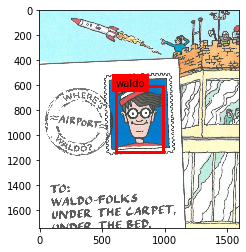

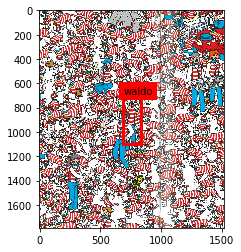

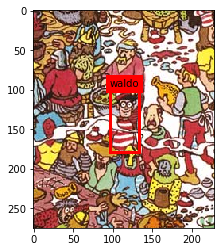

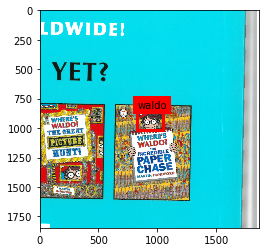

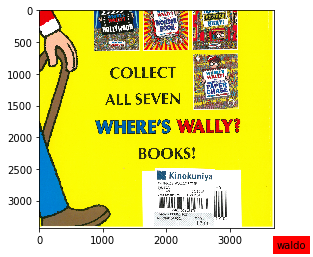

In [39]:
sampleImages = np.random.choice(pos_samples, 5, replace=False)

for idx, sample in enumerate(sampleImages):
    fig, ax = plt.subplots(1)
    plt.imshow(sample['img'])
    draw_bbox(ax, sample['name'], sample['bbox'])
    
plt.show()

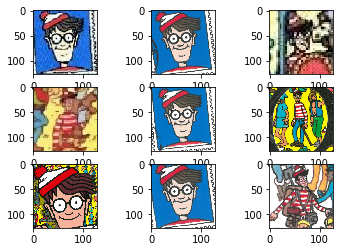

In [12]:
import pickle
import os
import cv2

waldos_file = os.path.join('cache_anno', os.sep, 'waldo.pkl')  
    
with open(waldos_file, 'rb') as f:
    waldos = pickle.load(f)
    
resized_waldos = []
for img in waldos:
    y,x = img.shape[:2]
    if x > y:
        y_new = int(128.0 * y / x)
        x_new = 128
        d = (128 - y_new) / 2
        img = cv2.resize(img, (x_new, y_new))
        resized = cv2.copyMakeBorder(img, math.floor(d), math.ceil(d), 0,0, cv2.BORDER_CONSTANT)
    else:
        x_new = int(128.0 * x / y)
        y_new = 128
        d = (128 - x_new) / 2
        img = cv2.resize(img, (x_new, y_new))
        resized = cv2.copyMakeBorder(img, 0, 0, math.floor(d), math.ceil(d), cv2.BORDER_CONSTANT)
    resized_waldos.append(resized)

waldos = resized_waldos
np.random.shuffle(waldos)

        
for idx, waldo in enumerate(waldos[:9]):
    ax = plt.subplot(3,3,idx +1)
    plt.imshow(waldo)

plt.show()

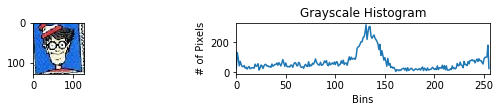

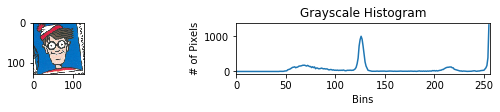

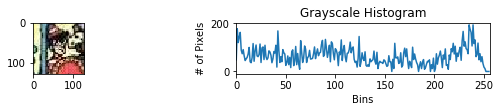

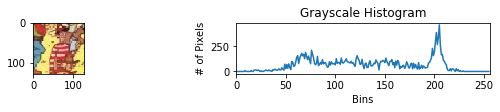

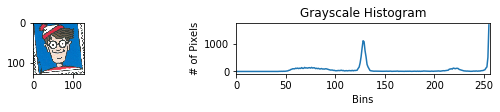

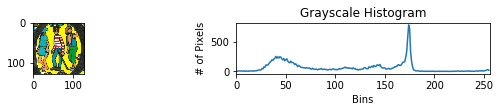

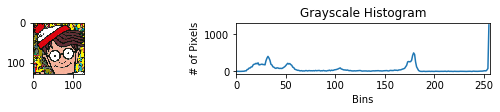

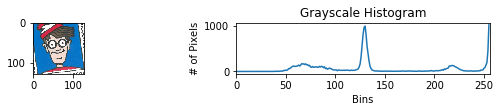

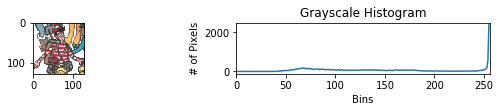

In [20]:
for idx, waldo in enumerate(waldos[:9]):
    gray = cv2.cvtColor(waldo, cv2.COLOR_BGR2GRAY)
    cv2.imshow("gray", gray)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(9,2,idx*2 +1)
    plt.imshow(waldo)

    plt.subplot(9,2,idx*2 +2)
    plt.plot(hist)
    plt.xlim([0, 256])
    plt.title("Grayscale Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    
    plt.show()
    

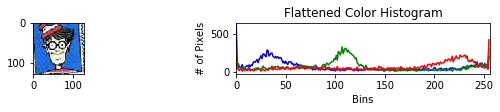

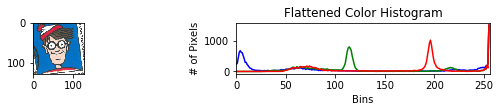

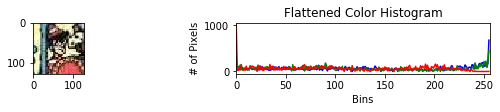

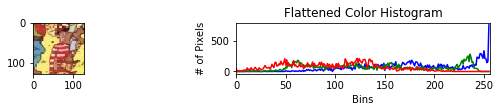

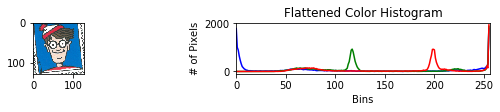

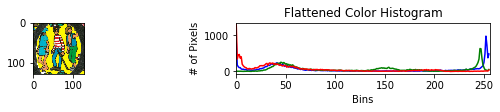

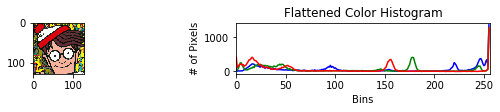

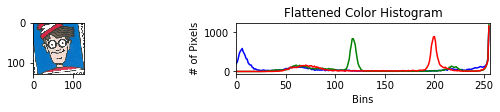

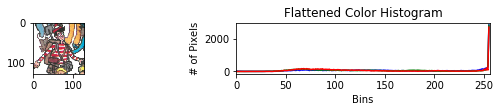

In [23]:
for idx, waldo in enumerate(waldos[:9]):
    channels = cv2.split(waldo)
    colors = ("b", "g", "r")
    plt.figure(figsize=(10,10))
    
    plt.subplot(9,2,idx*2 +1)
    plt.imshow(waldo)

    plt.subplot(9,2,idx*2 +2)
    plt.title("Flattened Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    features = []
    
    for (channel, color) in zip(channels, colors):
        hist = cv2.calcHist([channel], [0], None, [256], [0, 256])
        features.extend(hist)
 
        plt.plot(hist, color = color)
        plt.xlim([0, 256])
        
    plt.show()
    colorFeatures.append(features)


In [49]:
trained = []

for waldo in waldos[:2]:
    hist = cv2.calcHist(waldo, [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    trained.append(hist)
    
d = cv2.compareHist(trained[0], trained[1], cv2.HISTCMP_CORREL)
print('correlation: ', d)

correlation:  0.7035164542159946


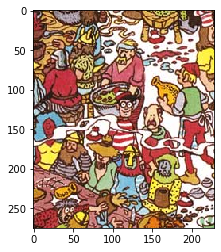

Total number of matches more than  0.7  similarity:  548


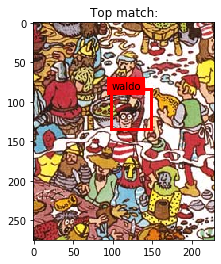

correlation:  0.8364917101020866


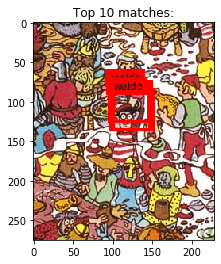

In [75]:
image = sampleImages[2]['img']
results = []

fig, ax = plt.subplots(1)
plt.imshow(image)

plt.show()

w = 25
simThreshold = 0.7

for i in range(w, image.shape[0]-w):
    for j in range(w, image.shape[1]-w):
        im = image[i-w:i+w, j-w:j+w]
        
        hist = cv2.calcHist(im, [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        
        for train in trained:
            d = cv2.compareHist(hist, train, cv2.HISTCMP_CORREL)
            if d > simThreshold:
                box = [j-w, i-w, j+w, i+w]
                results.append((box, d))
                break
        
results = sorted(results, key=lambda x: x[1], reverse=True)

print("Total number of matches more than ", simThreshold, " similarity: ", len(results))

fig, ax = plt.subplots(1)
plt.title("Top match:")
plt.imshow(image)
draw_bbox(ax, 'waldo', results[0][0])
plt.show()
print('correlation: ', results[0][1])

fig, ax = plt.subplots(1)
plt.title("Top 10 matches:")
plt.imshow(image)
for result in results[:10]:
    draw_bbox(ax, 'waldo', result[0])